In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoImageProcessor, BlipProcessor, BlipForConditionalGeneration
from PIL import Image
from datasets import load_dataset
from tqdm import tqdm_notebook as tqdm

## Loading the Data
Load and explore the ImageNette dataset

In [ ]:
dataset = load_dataset("frgfm/imagenette", "320px")

dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9469
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3925
    })
})

### Process the Images
Resize all images to 256x256, preserving aspect ratio with white background. We will combine all images in the training and testing sets for the project since this is not a supervised task.

In [ ]:
ALL_IMAGES = []

def get_fitted_image(im):
    sz = im.size
    fitted_im = Image.new('RGB', (sz[0], sz[1]), (255, 255, 255))
    fitted_im.paste(im, (0, 0))
    return np.array(fitted_im.resize((256, 256), Image.LANCZOS))

# Process all validation images
for im_id in tqdm(range(len(dataset["validation"]))):
    ALL_IMAGES.append({
        "image": get_fitted_image(dataset["validation"][im_id]["image"]),
        "category": dataset["validation"][im_id]["label"]
    })

# Process all training images
for im_id in tqdm(range(len(dataset["train"]))):
    ALL_IMAGES.append({
        "image": get_fitted_image(dataset["train"][im_id]["image"]),
        "category": dataset["train"][im_id]["label"]
    })

# Convert to a dataframe for easy management
ALL_IMAGES = pd.DataFrame(ALL_IMAGES)
ALL_IMAGES.head(10)

<ipython-input-5-1c405ae619fa>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for im_id in tqdm(range(len(dataset["validation"]))):


  0%|          | 0/3925 [00:00<?, ?it/s]

<ipython-input-5-1c405ae619fa>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for im_id in tqdm(range(len(dataset["train"]))):


  0%|          | 0/9469 [00:00<?, ?it/s]

,image,category
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",2
1,"[[[193, 184, 179], [194, 185, 180], [194, 184,...",2
2,"[[[25, 15, 13], [25, 15, 13], [25, 15, 13], [2...",2
3,"[[[254, 253, 255], [255, 255, 254], [253, 254,...",2
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",2
5,"[[[90, 92, 78], [93, 95, 81], [96, 98, 84], [9...",2
6,"[[[255, 255, 255], [255, 254, 255], [255, 255,...",2
7,"[[[187, 186, 184], [189, 188, 186], [190, 189,...",2
8,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",2
9,"[[[252, 254, 251], [252, 254, 251], [252, 254,...",2


Take the first 480 images from each category

In [ ]:
ALL_IMAGES = ALL_IMAGES.groupby(
    by='category',
    as_index=False
).head(480).sort_values("category")

ALL_IMAGES.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 541 to 7734
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     4800 non-null   object
 1   category  4800 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 112.5+ KB


### Display Image Samples

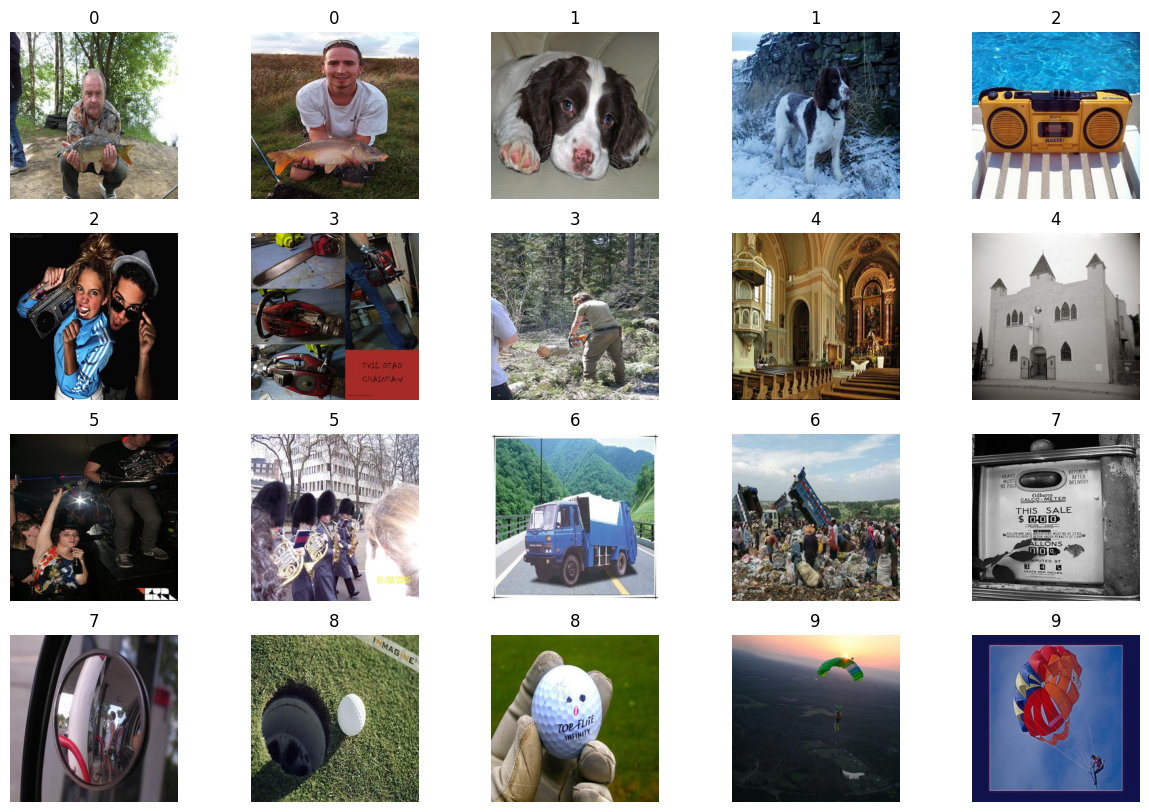

In [ ]:
to_print = ALL_IMAGES.groupby('category', as_index=False).head(2).sort_values("category")

_, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,10))

for idx in range(len(to_print)):
    sub_ax = ax[int(np.floor(idx / 5))][idx % 5]
    sub_ax.axis('off')

    if idx < len(to_print):
        im, cat = to_print.values[idx]
        sub_ax.imshow(im)
        sub_ax.set_title(cat)

plt.show()

## Generate Embeddings, Attention Weights, and Captions

### Load the Embeddings Model (SWIN Vision Transformer)

In [ ]:
embeddings_model_name = "microsoft/swin-base-patch4-window12-384-in22k"
embeddings_processor = AutoImageProcessor.from_pretrained(embeddings_model_name)
embeddings_model = AutoModel.from_pretrained(embeddings_model_name).to("cuda")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at microsoft/swin-base-patch4-window12-384-in22k were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Load the Captioning Model (BLIP Model)

In [ ]:
captioning_model_name = "Salesforce/blip-image-captioning-large"
captioning_processor = BlipProcessor.from_pretrained(captioning_model_name)
captioning_model = BlipForConditionalGeneration.from_pretrained(captioning_model_name).to("cuda")

### Generate!

In [ ]:
all_attentions = []
all_embeddings = []
all_captions = []

last_hidden_shape = None
attentions_shape = None
embeddings_shape = None

# Get the attention weights and embeddings in batches of 40
# to prevent the notebook from running out of memory
for start in tqdm(range(0, len(ALL_IMAGES), 40)):
    ims = list(ALL_IMAGES["image"][start:start+40])

    # Generate the embeddings
    embed_inputs = embeddings_processor(ims, return_tensors="pt").to("cuda")
    embed_last_hidden = embeddings_model(**embed_inputs).last_hidden_state

    if last_hidden_shape is None:
        last_hidden_shape = embed_last_hidden.shape

    # Get the weights of each attention window in the last layer
    attentions = embed_last_hidden.norm(dim=2)
    all_attentions += attentions.tolist()

    if attentions_shape is None:
        attentions_shape = attentions.shape

    # Get the embeddings
    embeds = embed_last_hidden.mean(axis=1)
    all_embeddings += embeds.tolist()
    
    if embeddings_shape is None:
        embeddings_shape = embeds.shape

    # The input and outputs of the models take a lot of memory,
    # so we delete them here since we are not using them again
    del embed_inputs, embed_last_hidden, embeds, attentions

    # Generate the captions
    caption_inputs = captioning_processor(ims, return_tensors="pt").to("cuda")
    caption_outputs = captioning_model.generate(max_new_tokens=32, **caption_inputs)
    all_captions += [captioning_processor.decode(o, skip_special_tokens=True) for o in caption_outputs]

    # The input and outputs of the models take a lot of memory,
    # so we delete them here since we are not using them again
    del caption_inputs, caption_outputs

    torch.cuda.empty_cache()

<ipython-input-10-9ab3e3ade746>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for start in tqdm(range(0, len(ALL_IMAGES), 40)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
print("Last Hidden State Shape:", last_hidden_shape)
print("--------------------------------------")
print("Attention Weights Shape:", attentions_shape)
print("Averaged Embeddings Shape:", embeddings_shape)

Last Hidden State Shape: torch.Size([40, 144, 1024])
--------------------------------------
Attention Weights Shape: torch.Size([40, 144])
Averaged Embeddings Shape: torch.Size([40, 1024])


In [ ]:
# Normalize the attention weights between 0 and 1
all_attentions = torch.tensor(all_attentions)
mn = all_attentions.min(1, keepdim=True)[0]
mx = all_attentions.max(1, keepdim=True)[0]

# Append the attentions, embeddings, and captions to the data frame
ALL_IMAGES["attention_weights"] = all_attentions.sub(mn).div(mx).tolist()
ALL_IMAGES["embedding"] = all_embeddings
ALL_IMAGES["captions"] = all_captions

# Delete unneeded variables
del all_attentions, all_embeddings, all_captions, mn, mx

In [ ]:
ALL_IMAGES

,image,category,attention_weights,embedding,captions
541,"[[[43, 39, 62], [41, 36, 60], [40, 36, 59], [4...",0,"[0.05418964475393295, 0.02181175723671913, 0.7...","[0.3958092927932739, -0.41102686524391174, 0.0...",there is a man kneeling down holding a fish in...
491,"[[[255, 255, 251], [255, 255, 251], [255, 255,...",0,"[0.05811980739235878, 0.010085792280733585, 0....","[0.04505084827542305, 0.4904085695743561, 0.07...",arafed fish caught on a fishing trip in the co...
492,"[[[181, 170, 152], [193, 182, 164], [192, 181,...",0,"[0.04152180999517441, 0.26502525806427, 0.7568...","[0.5317907929420471, -0.8023494482040405, 0.09...",arafed man holding a fish on a beach near a bo...
493,"[[[110, 135, 108], [110, 136, 111], [126, 151,...",0,"[0.06863167136907578, 0.020426800474524498, 0....","[0.30099257826805115, -0.8238896131515503, 0.0...",arafed fish caught in the river by a man in a ...
494,"[[[60, 60, 54], [71, 72, 66], [87, 88, 82], [6...",0,"[0.07256149500608444, 0.014937695115804672, 0....","[0.30781498551368713, -0.7023441791534424, 0.0...",a man kneeling down holding a fish in his hands
...,...,...,...,...,...
7748,"[[[235, 254, 248], [236, 254, 248], [237, 254,...",9,"[0.04415711760520935, 0.10343631356954575, 0.5...","[1.0861889123916626, -0.38086405396461487, 0.0...",there are many children standing under a large...
7749,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",9,"[0.07850949466228485, 0.058887965977191925, 0....","[0.6354748606681824, -0.8015273213386536, 0.09...",araffe flying a kite in a field with a car in ...
7750,"[[[41, 69, 112], [42, 71, 113], [40, 71, 112],...",9,"[0.06918736547231674, 0.05884794145822525, 0.6...","[0.38840368390083313, 0.36730003356933594, 0.0...",there are two people flying a kite on a beach
7692,"[[[166, 173, 183], [166, 173, 183], [166, 173,...",9,"[0.06393760442733765, 0.01447345782071352, 0.3...","[0.23467440903186798, -0.7407791614532471, 0.0...",araffe flying a kite with a british flag on it


In [ ]:
ALL_IMAGES.to_pickle("./processed_images.pkl")